In [1]:
!pwd

/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/validation


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import nclcmaps

## module to load phase from RMM1 and RMM2

In [3]:
def theta1_cal( pc1, pc2 ):
    theta1           =  np.zeros(pc2.size)
    angle180         =  np.arctan2(-pc2, -pc1) * 180 / np.pi
    indNeg           =  np.where(angle180<0)[0]
    angle360         = angle180
    angle360[indNeg] = angle180[indNeg] + 360
    theta1           = np.around( ( angle360 + 22.5 ) * 8 / 360 )

    
    return theta1

def lowpass_scipy(signal,sample_freq,time_period,keep_mean):
    import numpy as np
    import scipy as sc
    from scipy import fftpack
    
    lowpass_signal=np.zeros(signal.shape)
    if any(np.isnan(signal)):
        raise ValueError('There is NaN in the signal')
    else:
        hf = 1./time_period

        temp_fft = sc.fftpack.fft(signal)

        fftfreq = np.fft.fftfreq(len(signal),sample_freq) ### daily data it is 1./365 ## monthly data 1./12 ## yearly data=1
          
        i1 = np.abs(fftfreq) >= hf  
        
        temp_fft[i1] = 0
        if not(keep_mean):
            temp_fft[0]=0
        lowpass_signal= np.real_if_close(sc.fftpack.ifft(temp_fft))
    
    return lowpass_signal

## cloud fraction

In [4]:
cloud_frac = xr.open_dataset('trop_ano_fraction_cloud_1952-2008_4_remap_new.nc')
cloud_frac

<xarray.Dataset>
Dimensions:      (lat: 15, lon: 90, time: 20851)
Coordinates:
  * time         (time) datetime64[ns] 1951-12-01 1951-12-02 ... 2008-12-31
  * lon          (lon) float64 0.0 4.0 8.0 12.0 16.0 ... 344.0 348.0 352.0 356.0
  * lat          (lat) float64 -28.64 -24.55 -20.45 -16.36 ... 20.45 24.55 28.64
Data variables:
    cloud_cover  (time, lat, lon) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.7.1 (http://mpimet.mpg.d...
    history:      Sun Jan 12 23:56:09 2020: cdo sellonlatbox,0,360,-30,30 ano...
    Conventions:  CF-1.6
    CDO:          Climate Data Operators version 1.9.7.1 (http://mpimet.mpg.d...

## WH04 RMM 

In [5]:
rmm = xr.open_dataset('RMM_WH04_index_new.nc')
rmm1 = rmm['PC1'].loc['1979-01-01':'2008-12-31']
rmm2 = rmm['PC2'].loc['1979-01-01':'2008-12-31']
amp = rmm['MJO_INDEX']
phase = theta1_cal( rmm1, rmm2 )

rm11 = np.real(lowpass_scipy(rmm1.values,sample_freq=1,time_period=10,keep_mean=1))
rmm11 = pd.Series(rm11,index  = rmm1.time.values)

rm22 = np.real(lowpass_scipy(rmm2.values,sample_freq=1,time_period=10,keep_mean=1))
rmm22 = pd.Series(rm22,index  = rmm2.time.values)


amp1_wh04 = (rmm11**2+rmm22**2)**0.5
phase1_wh04 = theta1_cal( rmm11, rmm22 )

cloud_frac1_wh04 = cloud_frac.sel(time=phase1_wh04.index)
1.5*np.std(amp1_wh04),np.std(amp1_wh04),np.std(rmm1.loc['1979-01-01':'2008-12-31'])

(0.9762772579553216, 0.6508515053035477, <xarray.DataArray 'PC1' ()>
 array(1.01327797))

In [47]:
st = 1979;en = 2008

## CONV

In [48]:
#df1 = pd.read_csv('rmm1_1905_2015_svr_predict.txt')
df1 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/conv1d/ensamble4/ensamble_conv1d_jgrjd_rmm1_p1.csv')
df1.columns = ['Datetime','rmm1']

df1.index = pd.to_datetime(df1.Datetime)
df1 = df1.drop('Datetime',axis=1)
# df1 = df1[['rmm1']]/df1['rmm1'].std()
#df2 = pd.read_csv('rmm2_1905_2015_svr_predict.txt')
df2 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/conv1d/ensamble4/ensamble_conv1d_jgrjd_rmm2.csv')
df2.columns = ['Datetime','rmm2']

df2.index = pd.to_datetime(df2.Datetime)
df2 = df2.drop('Datetime',axis=1)
# df2 = df2[['rmm2']]/df2['rmm2'].std()

df1.columns =['rmm1']
df2.columns =['rmm2']


d1_conv = df1['rmm1'][(df1.index >= datetime.datetime(st,1,1)) & (df1.index  <= datetime.datetime(en,12,31))]
d2_conv = df2['rmm2'][(df2.index >= datetime.datetime(st,1,1)) & (df2.index  <= datetime.datetime(en,12,31))]

mjo_ind_conv = (d1_conv**2+d2_conv**2)**0.5

phase1_conv = theta1_cal( d1_conv, d2_conv )
amp1_conv = mjo_ind_conv.loc[str(st)+'-01-01':str(en)+'-12-31']
cloud_frac1_conv = cloud_frac.sel(time=phase1_conv.index)
1.5*np.std(amp1_conv),np.std(amp1_conv),np.std(d1_conv),np.std(d2_conv)


(0.9806257098901967,
 0.6537504732601311,
 0.9999543701945892,
 0.9999543701945898)

## Oliver 

In [49]:
df2 = pd.read_csv('rmm_oliver_20CRv3.csv')
df2['Datetime'] = df2.year.map(str) + '-' + df2.month.map(str) + '-'+df2.day.map(str) 
df2.index = pd.to_datetime(df2.Datetime)
df2 = df2.drop('Datetime',axis=1)

df2['IHR1'] = df2[['IHR1']]/df2['IHR1'].loc['1979-01-01':'2008-12-31'].std()
df2['IHR2'] = df2[['IHR2']]/df2['IHR2'].loc['1979-01-01':'2008-12-31'].std()

d1_ol = df2['IHR1'][(df2.index >= datetime.datetime(st,1,1)) & (df2.index  <= datetime.datetime(en,12,31))]
d2_ol = df2['IHR2'][(df2.index >= datetime.datetime(st,1,1)) & (df2.index  <= datetime.datetime(en,12,31))]

mjo_ind_ol = (d1_ol**2+d2_ol**2)**0.5


phase1_ol = theta1_cal( d1_ol, d2_ol )
amp1_ol = mjo_ind_ol.loc[str(st)+'-01-01':str(en)+'-12-31']
cloud_frac1_ol = cloud_frac.sel(time=phase1_ol.index)
1.5*np.std(amp1_ol),np.std(amp1_ol),np.std(d1_ol),np.std(d2_ol)

(1.0238181049580053, 0.6825454033053369, 0.9999543701945903, 0.999954370194587)

## MLR

In [50]:
#df1 = pd.read_csv('rmm1_1905_2015_svr_predict.txt')
df1 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/multiple_regression/rmm1_MLR_org.txt')
df1.columns = ['Datetime','rmm1']

df1.index = pd.to_datetime(df1.Datetime)
df1 = df1.drop('Datetime',axis=1)
df1 = df1[['rmm1']]/df1['rmm1'].loc['1979-01-01':'2008-12-31'].std()
#df2 = pd.read_csv('rmm2_1905_2015_svr_predict.txt')
df2 = pd.read_csv('/home/cccr/supriyo/panini/filtered_data/historical/JGRJD/multiple_regression/rmm2_MLR_org.txt')
df2.columns = ['Datetime','rmm2']

df2.index = pd.to_datetime(df2.Datetime)
df2 = df2.drop('Datetime',axis=1)
df2 = df2[['rmm2']]/df2['rmm2'].loc['1979-01-01':'2008-12-31'].std()

df1.columns =['rmm1']
df2.columns =['rmm2']



d1_mlr = df1['rmm1'][(df1.index >= datetime.datetime(st,1,1)) & (df1.index  <= datetime.datetime(en,12,31))]
d2_mlr = df2['rmm2'][(df2.index >= datetime.datetime(st,1,1)) & (df2.index  <= datetime.datetime(en,12,31))]

mjo_ind_mlr = (d1_mlr**2+d2_mlr**2)**0.5

phase1_mlr = theta1_cal( d1_mlr, d2_mlr )
amp1_mlr = mjo_ind_mlr.loc[str(st)+'-01-01':str(en)+'-12-31']
cloud_frac1_mlr = cloud_frac.sel(time=phase1_mlr.index)
1.5*np.std(amp1_mlr),np.std(amp1_mlr),np.std(d1_mlr),np.std(d2_mlr)

(1.0223506213104732,
 0.6815670808736487,
 0.9999543701945891,
 0.9999543701945888)

In [51]:
# print(np.corrcoef(d1_conv,rmm1.loc['1979-01-01':'2008-12-31'])[0,1])
# print(np.corrcoef(d1_ol,rmm1.loc['1979-01-01':'2008-12-31'])[0,1])
# print(np.corrcoef(d2_conv,rmm2.loc['1979-01-01':'2008-12-31'])[0,1])
# print(np.corrcoef(d2_ol,rmm2.loc['1979-01-01':'2008-12-31'])[0,1])

## test a single plot

In [52]:
# import cartopy.crs as ccrs
# import matplotlib.pyplot as plt
# from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# ind1 = np.zeros((8,),dtype=object)
# for i in range(8):
#     ind1[i] = np.intersect1d( np.where(amp1_wh04>1.0)[0], np.where(phase1_wh04==i+1)[0] )

# ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

# cloud_frac1_wh04.isel(time=ind1[7]).mean(dim='time').cloud_cover.plot.contourf(ax=ax,transform = ccrs.PlateCarree(), vmin=-10, vmax= 10, cmap='RdBu_r',
#         add_colorbar=True, extend='both')
# ax.coastlines()

In [53]:
# fig, ax = plt.subplots(8,1,figsize=(15,20))
# cmap1 = nclcmaps.cmap('BlueWhiteOrangeRed')
# levels = np.arange(-10,12,2)
# im = []
# for i in range(8):
#     ax1 = plt.subplot(8,1,i+1,projection=ccrs.PlateCarree(central_longitude=180.0))
#     im.append(cloud_frac1.isel(time=ind1[i]).mean(dim='time').cloud_cover.plot.contourf(ax=ax1,transform = ccrs.PlateCarree(),levels=levels, cmap=cmap1,add_colorbar= False, extend='both'))
#     ax1.coastlines()
#     ax1.set_xticks([0, 60, 120, 180, 240, 300, 360], crs=ccrs.PlateCarree())
#     ax1.set_yticks([-30,-15, 0, 15, 30], crs=ccrs.PlateCarree())
#     lon_formatter = LongitudeFormatter(zero_direction_label=True)
#     lat_formatter = LatitudeFormatter()
#     ax1.xaxis.set_major_formatter(lon_formatter)
#     ax1.yaxis.set_major_formatter(lat_formatter)
#     ax1.set_xlabel('')
#     ax1.set_ylabel('')
#     ax1.set_title('Phase '+str(i+1))


# fig.colorbar(im[7], ax=ax,orientation="horizontal",fraction=0.07,anchor=(0.5,-1.0),shrink=0.60,pad=0.2)
# plt.show()
# # plt.savefig('test1.png')

In [54]:
def make_composite_propagation(phase1,amp1,cloud_frac1,title):
    plt.rcParams['font.weight'] = 'normal'
    plt.rcParams['font.size'] = 25
    plt.rcParams['image.cmap'] = 'seismic'
    ind1 = np.zeros((8,),dtype=object)
    for i in range(8):
        ind1[i] = np.intersect1d( np.where(amp1>1.5*np.std(amp1))[0], np.where(phase1==i+1)[0] )
        print(len(ind1[i]))
        
    fig, ax = plt.subplots(8,1,figsize=(15,20))
    plt.subplots_adjust(top=1.3) 
    cmap1 = nclcmaps.cmap('BlueWhiteOrangeRed')
    levels = np.arange(-12,14,2)
    im = []
    for i in range(8):
        ax1 = plt.subplot(8,1,i+1,projection=ccrs.PlateCarree(central_longitude=180.0))
        im.append(cloud_frac1.isel(time=ind1[i]).mean(dim='time').cloud_cover.plot.contourf(ax=ax1,transform = ccrs.PlateCarree(),levels=levels, cmap=cmap1,add_colorbar= False, extend='both'))
        ax1.coastlines()
#         ax1.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='#7f7f7f',facecolor='#B1B2B4')
        ax1.set_xticks([0, 60, 120, 180, 240, 300, 360], crs=ccrs.PlateCarree())
        ax1.set_yticks([-30,-15, 0, 15, 30], crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax1.xaxis.set_major_formatter(lon_formatter)
        ax1.yaxis.set_major_formatter(lat_formatter)
        ax1.set_xlabel('')
        ax1.set_ylabel('')
        ax1.set_title(title+' Phase '+str(i+1))

    fig.colorbar(im[7], ax=ax,orientation="horizontal",fraction=0.07,anchor=(0.5,-1.0),shrink=0.60,pad=0.5)
    return ind1

921
898
815
806
867
921
842
778


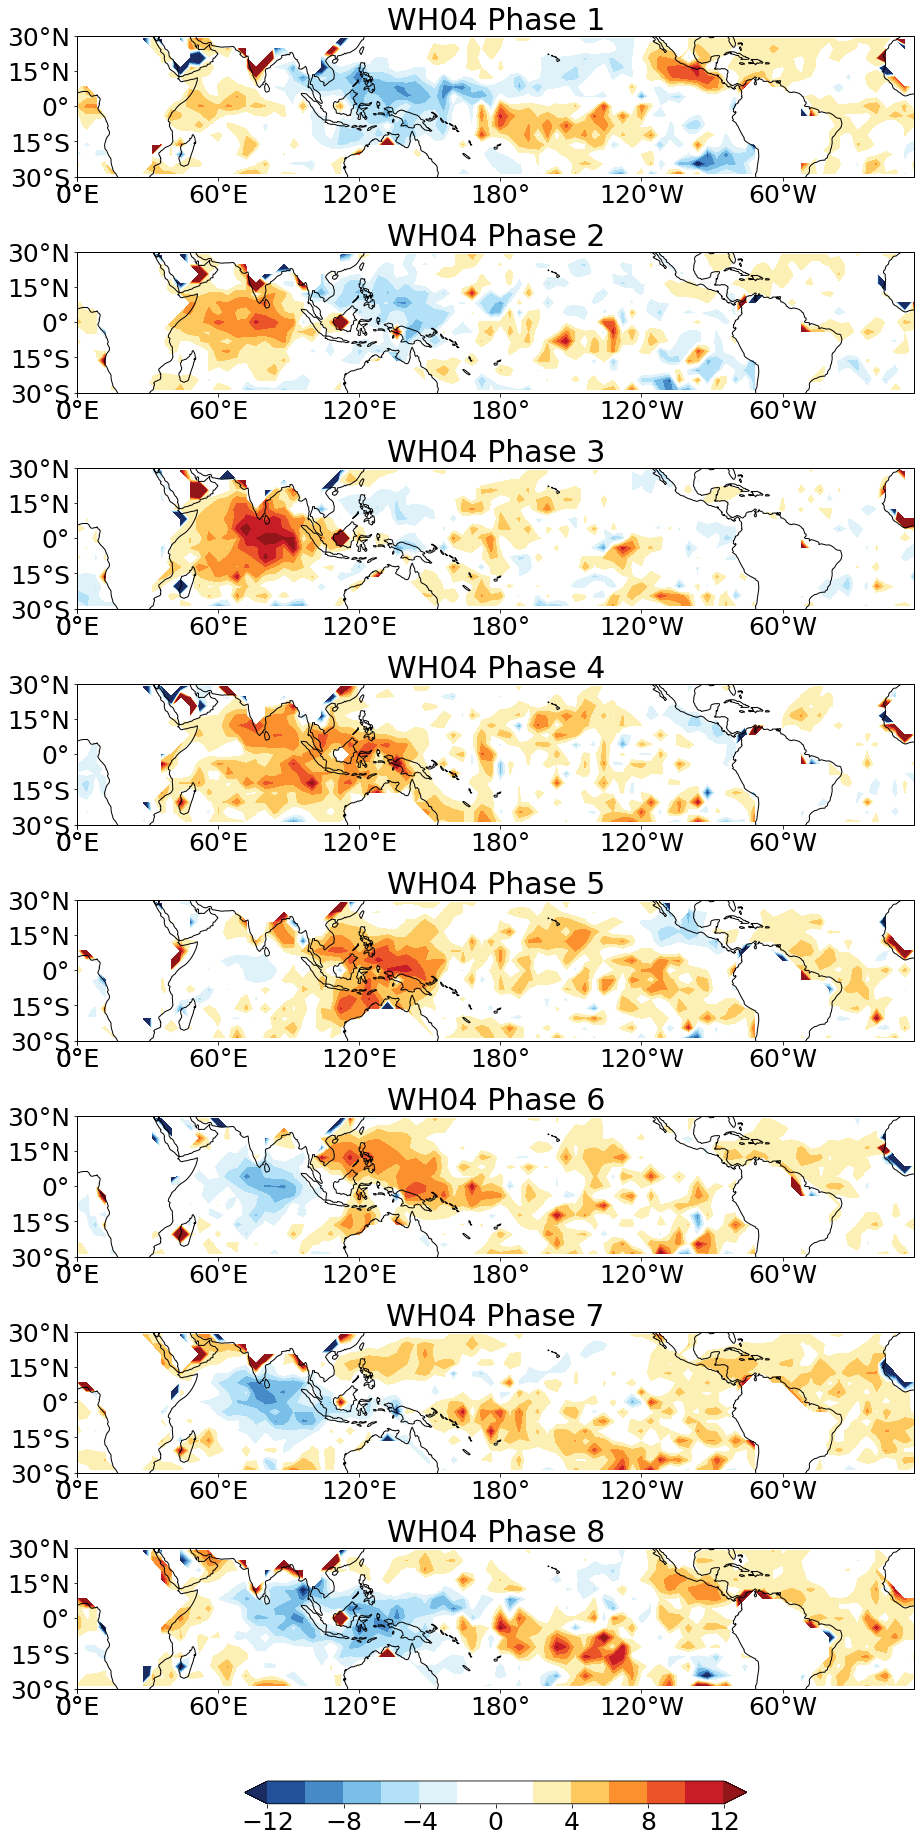

In [55]:
ind1_wh04 = make_composite_propagation(phase1_wh04,amp1_wh04,cloud_frac1_wh04,'WH04')
plt.savefig('/home/cccr/supriyo/panini/jgrjd_figure/modified/sup_2.1.png',dpi=300,bbox_inches='tight')

801
759
818
723
844
833
657
799


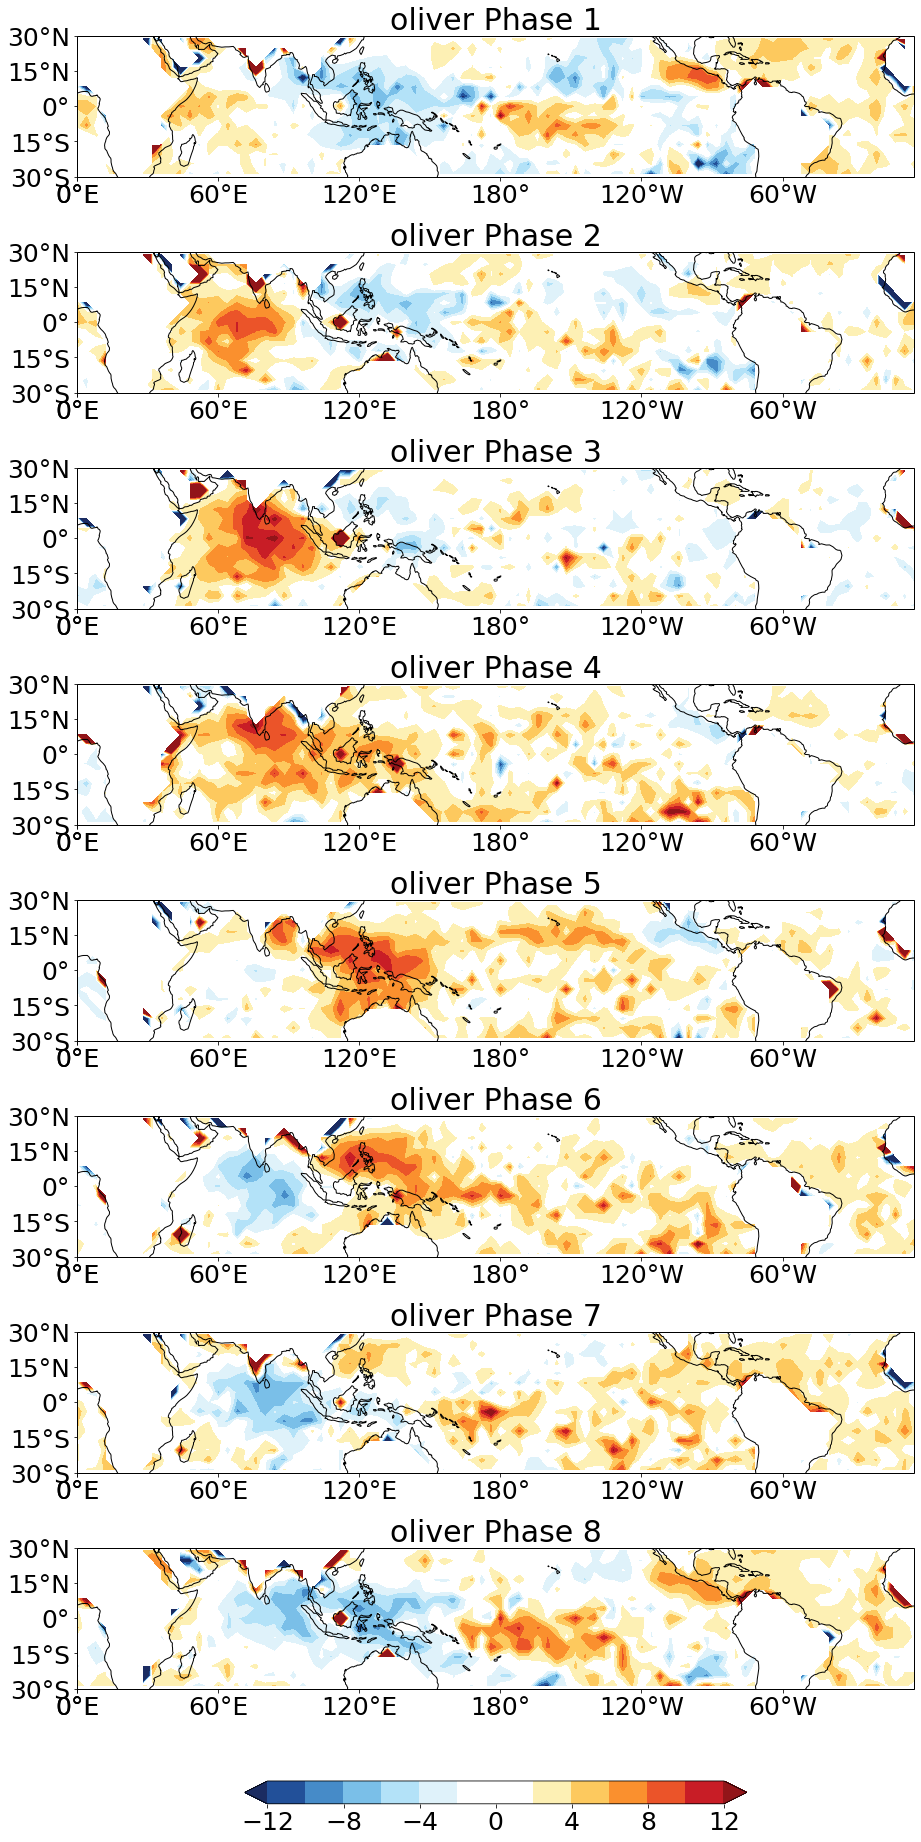

In [32]:
ind1_ol = make_composite_propagation(phase1_ol,amp1_ol,cloud_frac1_ol,'oliver')
# plt.savefig('/home/cccr/roxy/panini/JGRJD_PHD_PART_I/JGRJD_DESKTOP/MJO_reconstruct_jgrjd/models/validation/oliver_prop.png',dpi=600)

933
818
845
854
862
845
807
824


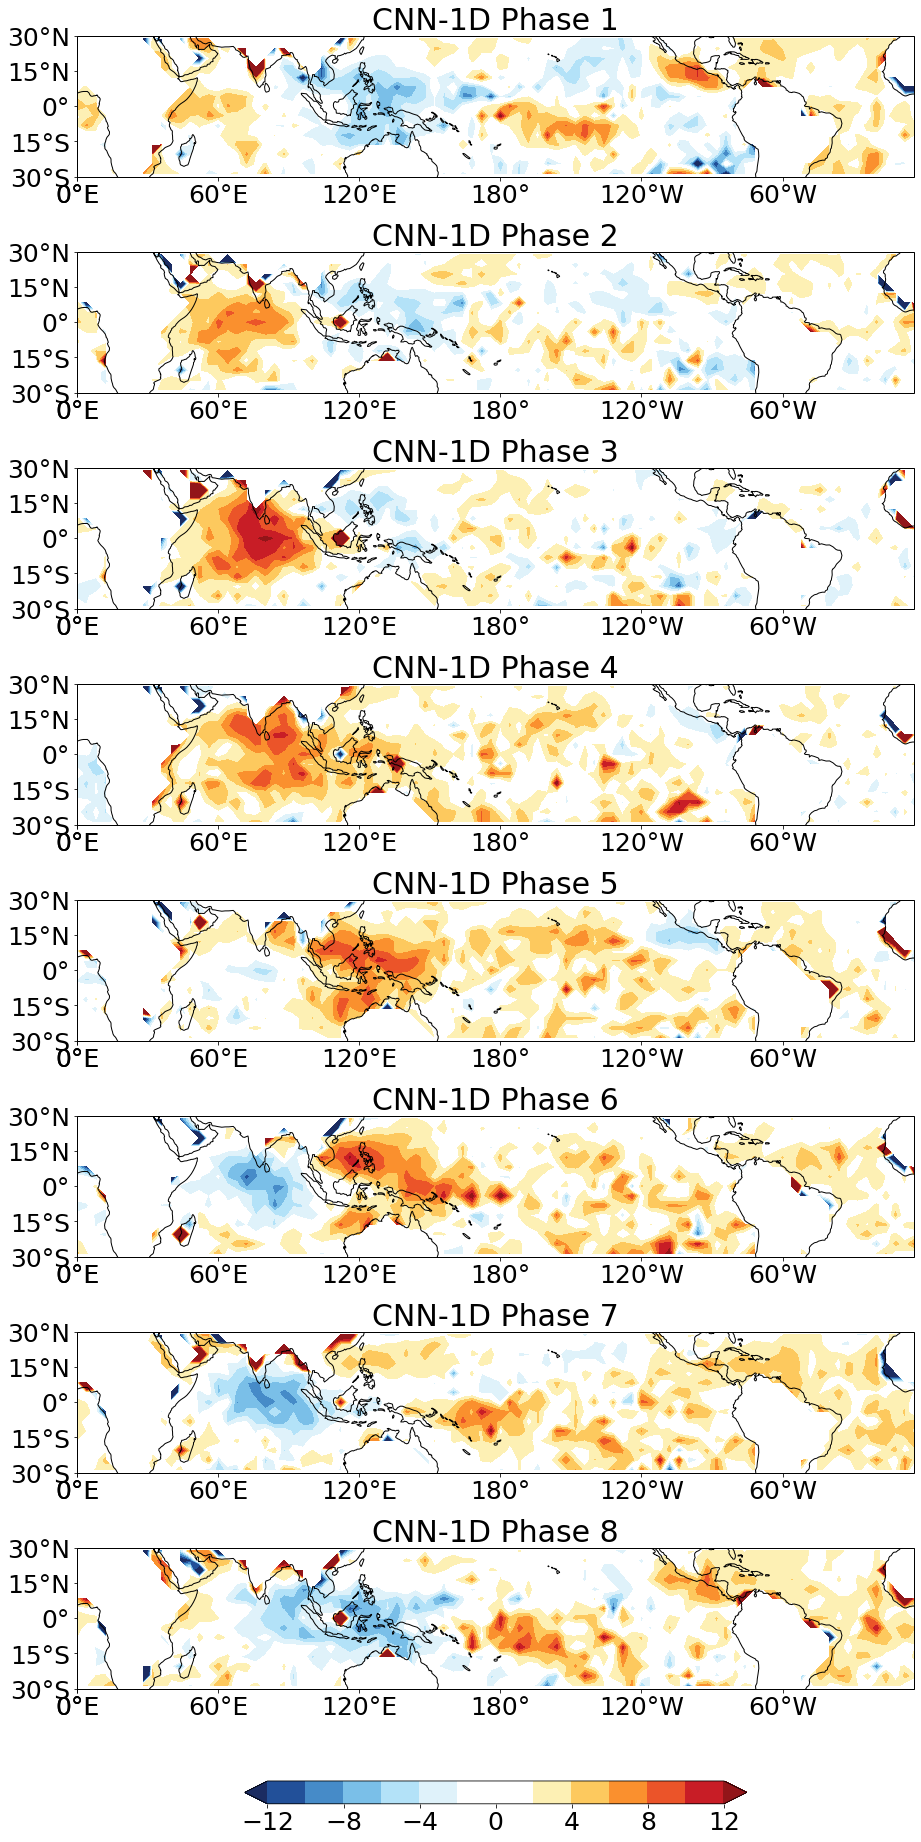

In [56]:
ind1_conv= make_composite_propagation(phase1_conv,amp1_conv,cloud_frac1_conv,'CNN-1D')
plt.savefig('/home/cccr/supriyo/panini/jgrjd_figure/modified/sup_2.2.png',dpi=300,bbox_inches='tight')

In [ ]:
convmatch =np.zeros(8,)
olmatch =np.zeros(8,)
mlrmatch = np.zeros(8,)
rat_conv= np.zeros(8,)
rat_ol = np.zeros(8,)
rat_mlr = np.zeros(8,)

wh04_occ = np.zeros(8,)

for i in range(8):
    convmatch[i] = len(np.intersect1d(ind1_wh04[i],ind1_conv[i]))
    olmatch[i]   = len(np.intersect1d(ind1_wh04[i],ind1_ol[i]))
    mlrmatch[i]   = len(np.intersect1d(ind1_wh04[i],ind1_mlr[i]))

    rat_conv[i]  =  convmatch[i]/len(ind1_conv[i])
    rat_ol[i]    =  olmatch[i]/len(ind1_ol[i])
    rat_mlr[i]    =  mlrmatch[i]/len(ind1_mlr[i])

    wh04_occ[i]  =  len(ind1_wh04[i])

plt.plot(np.arange(1,9,1),convmatch/wh04_occ,'-o')
plt.plot(np.arange(1,9,1),olmatch/wh04_occ,'-o')
plt.plot(np.arange(1,9,1),mlrmatch/wh04_occ,'-o')

# plt.plot(np.arange(1,9,1),wh04_occ,'-o')

convmatch/wh04_occ-olmatch/wh04_occ,convmatch/wh04_occ-mlrmatch/wh04_occ

In [ ]:
plt.plot(np.arange(1,9,1),rat_conv,'-o')
plt.plot(np.arange(1,9,1),rat_ol,'-o')
plt.plot(np.arange(1,9,1),rat_mlr,'-o')

rat_conv,rat_ol

In [ ]:

plt.figure(figsize=(16,8))
n1,x1,_=plt.hist(amp1_wh04,bins=35,density=True,alpha=0.5,histtype='step',label='observed')
# bin_centers1 = 0.5*(x1[1:]+x1[:-1])
# plt.plot(bin_centers1,n1,'r',label='observed')


n2,x2,_=plt.hist(amp1_conv,bins=35,density=True,alpha=0.5,histtype='step',label='conv')
# bin_centers2 = 0.5*(x2[1:]+x2[:-1])
# plt.plot(bin_centers2,n2,'g',label='conv')



n3,x3,_=plt.hist(amp1_ol,bins=50,density=True,alpha=0.5,histtype='step',label='oliver');
# bin_centers3 = 0.5*(x3[1:]+x3[:-1])
# plt.plot(bin_centers3,n3,'b',label='oliver')


plt.legend()

In [ ]:
plt.figure(figsize=(16,8))

bin_centers1 = 0.5*(x1[1:]+x1[:-1])
plt.plot(bin_centers1,n1,'r',label='observed')
bin_centers2 = 0.5*(x2[1:]+x2[:-1])
plt.plot(bin_centers2,n2,'g',label='conv')
bin_centers3 = 0.5*(x3[1:]+x3[:-1])
plt.plot(bin_centers3,n3,'b',label='oliver')
plt.legend()